In [1]:
import pandas as pd
import numpy as np
import re
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix


df = pd.read_csv("Reviews.csv")[['Text', 'Score']].dropna()

In [2]:
groups = [g for _, g in df.groupby("Score")]
min_count = min(len(g) for g in groups)
df_balanced = pd.concat([
    resample(g, replace=False, n_samples=min_count, random_state=42)
    for g in groups
]).sample(frac=1, random_state=42)

print("Balanced star counts:\n", df_balanced['Score'].value_counts())

Balanced star counts:
 Score
2    29769
1    29769
3    29769
5    29769
4    29769
Name: count, dtype: int64


In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text) 
    return text

df_balanced['clean_text'] = df_balanced['Text'].astype(str).apply(clean_text)


In [ ]:
max_words = 10000   
max_len = 100      

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(df_balanced['clean_text'])

X = tokenizer.texts_to_sequences(df_balanced['clean_text'])
X = pad_sequences(X, maxlen=max_len, padding='post')


In [ ]:
y = df_balanced['Score'].values - 1


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    Bidirectional(LSTM(128, return_sequences=False)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(5, activation='softmax')   
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

c:\Users\HP\anaconda3\envs\tf_env312\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [14]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=128,
    validation_split=0.2
)


loss, acc = model.evaluate(X_test, y_test, verbose=2)
print(f"\n✅ Test Accuracy: {acc*100:.2f}%")

Epoch 1/20
745/745 ━━━━━━━━━━━━━━━━━━━━ 203s 270ms/step - accuracy: 0.4555 - loss: 1.2425 - val_accuracy: 0.5276 - val_loss: 1.1017
Epoch 2/20
745/745 ━━━━━━━━━━━━━━━━━━━━ 202s 271ms/step - accuracy: 0.5594 - loss: 1.0518 - val_accuracy: 0.5561 - val_loss: 1.0522
Epoch 3/20
745/745 ━━━━━━━━━━━━━━━━━━━━ 265s 356ms/step - accuracy: 0.6171 - loss: 0.9387 - val_accuracy: 0.5726 - val_loss: 1.0350
Epoch 4/20
745/745 ━━━━━━━━━━━━━━━━━━━━ 219s 294ms/step - accuracy: 0.6641 - loss: 0.8344 - val_accuracy: 0.5879 - val_loss: 1.0438
Epoch 5/20
745/745 ━━━━━━━━━━━━━━━━━━━━ 312s 419ms/step - accuracy: 0.7080 - loss: 0.7398 - val_accuracy: 0.5926 - val_loss: 1.0612
Epoch 6/20
745/745 ━━━━━━━━━━━━━━━━━━━━ 230s 308ms/step - accuracy: 0.7473 - loss: 0.6509 - val_accuracy: 0.5980 - val_loss: 1.1209
Epoch 7/20
745/745 ━━━━━━━━━━━━━━━━━━━━ 250s 336ms/step - accuracy: 0.7817 - loss: 0.5723 - val_accuracy: 0.5943 - val_loss: 1.2296
Epoch 8/20
745/745 ━━━━━━━━━━━━━━━━━━━━ 271s 363ms/step - accuracy: 0.8058 -

In [15]:
y_pred = model.predict(X_test).argmax(axis=1)
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=["1 star","2 stars","3 stars","4 stars","5 stars"]))


931/931 ━━━━━━━━━━━━━━━━━━━━ 27s 29ms/step

Classification Report:
               precision    recall  f1-score   support

      1 star       0.68      0.69      0.68      5954
     2 stars       0.57      0.58      0.58      5953
     3 stars       0.54      0.58      0.56      5954
     4 stars       0.56      0.52      0.54      5954
     5 stars       0.67      0.64      0.66      5954

    accuracy                           0.60     29769
   macro avg       0.60      0.60      0.60     29769
weighted avg       0.60      0.60      0.60     29769



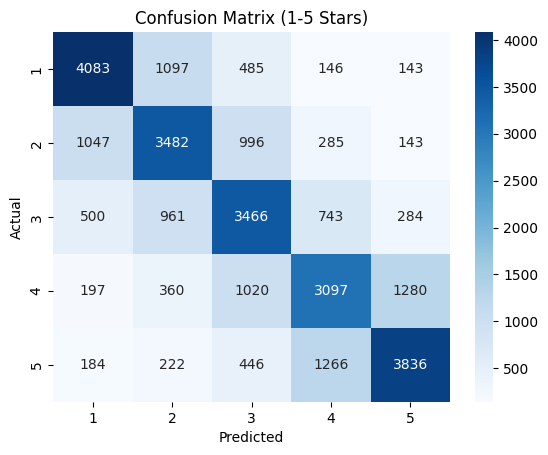

In [16]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["1","2","3","4","5"], yticklabels=["1","2","3","4","5"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (1-5 Stars)")
plt.show()


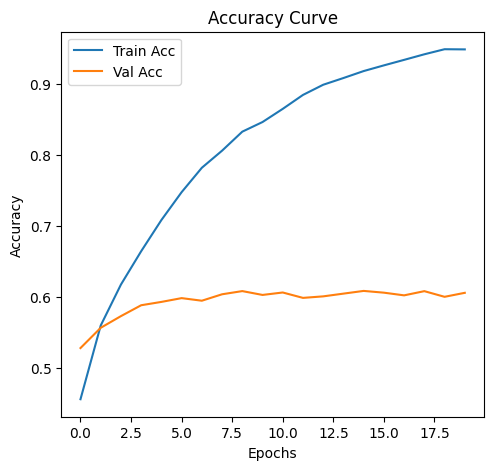

In [17]:
plt.figure(figsize=(12,5))





plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

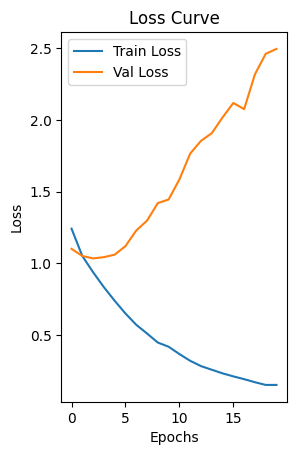

In [18]:
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.show()

In [ ]:
import pickle


with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)




In [ ]:
def predict_review(text, model, tokenizer, max_len=100):
   
    text_clean = clean_text(text)
    
  
    seq = tokenizer.texts_to_sequences([text_clean])
    

    pad = pad_sequences(seq, maxlen=max_len, padding='post')
    
  
    pred = model.predict(pad, verbose=0)
    star = pred.argmax(axis=1)[0] + 1  
    
    
    return star, pred


In [23]:
text1 = "worst"
text2 = "Terrible quality, very disappointed."
text3 = "It was okay, nothing special but not bad."

print("Review:", text1, "→ Predicted Stars:", predict_review(text1, model, tokenizer)[0])
print("Review:", text2, "→ Predicted Stars:", predict_review(text2, model, tokenizer)[0])
print("Review:", text3, "→ Predicted Stars:", predict_review(text3, model, tokenizer)[0])


Review: worst → Predicted Stars: 1
Review: Terrible quality, very disappointed. → Predicted Stars: 1
Review: It was okay, nothing special but not bad. → Predicted Stars: 3


In [ ]:
from tensorflow.keras.models import load_model
import pickle

model.save("sentiment_bilstm.h5")


with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)


In [25]:
from tensorflow.keras.models import load_model

model = load_model("sentiment_bilstm.h5", compile=False)


In [26]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


In [ ]:
model.save("sentiment_bilstm.keras")  
import pickle
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)